# OpenIFS biases

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [22]:
from dask.distributed import Client, LocalCluster, wait

In [23]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34387 instead
  http_address["port"], self.http_server.port


In [24]:
client

Client Scheduler: tcp://127.0.0.1:36307 Dashboard: http://127.0.0.1:34387/status,Cluster Workers: 4 Cores: 8 Memory: 64.00 GB


In [25]:
exp_list = ['focioifs-merge14']

In [26]:
# OpenIFS surface
ds_sfc_all = []
for exp in exp_list:
    sfc = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_sfc.nc' % (exp,)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords').rename({'time_counter':'time'})
    ds_sfc_all.append(ds_sfc)

In [27]:
# OpenIFS plev
ds_pl_all = []
for exp in exp_list:
    pl = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_pl.nc' % (exp,)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords').rename({'time_counter':'time'})
    ds_pl_all.append(ds_pl)

## SST and CI

In [ ]:
# Plot settings
prj = ccrs.PlateCarree()
tmin1 = -2
tmax1 = 30
tmin2 = -5
tmax2 = 5
cmin1 = 0
cmax1 = 1
cmin2 = -0.4
cmax2 = 0.4

cmap1 = cmocean.cm.thermal
cmap2 = cmocean.cm.balance
imap1 = cmocean.cm.ice
imap2 = cmocean.cm.balance

# HadSST and ice
hadisst = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'
hadiice = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_ice.nc'

ds_hadsst = xr.open_dataset(hadisst).rename({'longitude':'lon','latitude':'lat'})
ds_hadice = xr.open_dataset(hadiice).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
sic_had = ds_hadice['sic'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    
    # Convert SST to Celsius and CI to percent
    sst = ds_sfc['sstk'][-360:].groupby('time.season').mean('time') - 273.15
    ci  = ds_sfc['ci'][-360:].groupby('time.season').mean('time') 
    
    sst_180 = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180))
    ci_180  = ci.assign_coords(lon=(((ci.lon + 180) % 360) - 180))
    
    sst_i = sst_180.interp_like(sst_had)
    ci_i  = ci_180.interp_like(sic_had)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        for ax in axs: ax.add_feature(cfeature.LAND,zorder=1)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
        sst.sel(season=season).plot(ax=axs[0],vmin=tmin1,vmax=tmax1,cmap=cmap1,cbar_kwargs=ckw)
        (sst_i - sst_had).sel(season=season).plot(ax=axs[1],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'CI [fraction]'}
        ci.sel(season=season).plot(ax=axs[2],vmin=cmin1,vmax=cmax1,cmap=imap1,cbar_kwargs=ckw)
        (ci_i - sic_had).sel(season=season).plot(ax=axs[3],cmap=imap2,vmin=cmin2,vmax=cmax2,cbar_kwargs=ckw)
        
        axs[1].set_title('SST (%s): %s - HadISST' % (season,exp))
        axs[0].set_title('SST (%s): %s' % (season,exp))
        axs[3].set_title('CI (%s): %s - HadISST' % (season,exp))
        axs[2].set_title('CI (%s): %s' % (season,exp))
        
        for ax in axs:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        fig.tight_layout()
        fig.savefig('sst_biases_%s.png' % (season,),format='png',dpi=600)


In [ ]:
# Recreate Matthes et al 2020
prj = ccrs.PlateCarree()
tmin2 = -6
tmax2 = 6

cmap1 = cmocean.cm.thermal
cmap2 = cmocean.cm.balance

# HadSST and ice
hadisst = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'
hadiice = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_ice.nc'

ds_hadsst = xr.open_dataset(hadisst).rename({'longitude':'lon','latitude':'lat'})
ds_hadice = xr.open_dataset(hadiice).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1980-01-01','2010-01-01')).mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    
    # Convert SST to Celsius and CI to percent
    sst = ds_sfc['sstk'][-360:].mean('time') - 273.15
    sst_180 = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180))
    sst_i = sst_180.interp_like(sst_had)
    
    fig = plt.figure(figsize=(6,10))
    axs = []
    axs.append( fig.add_subplot(2,1,1,projection=prj) )
    axs.append( fig.add_subplot(2,1,2,projection=prj) )
        
    for ax in axs: ax.add_feature(cfeature.LAND,zorder=1)
        
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
    (sst_i - sst_had).plot.pcolormesh(ax=axs[0],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
    (sst_i - sst_had).plot.pcolormesh(ax=axs[1],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
    (sst_i - sst_had).plot.contour(ax=axs[0],colors='k',levels=np.arange(tmin2,tmax2+1,1))
    (sst_i - sst_had).plot.contour(ax=axs[1],colors='k',levels=np.arange(tmin2,tmax2+1,1))
    
    for ax in axs:
        ax.coastlines()
        ax.set_title('SST: %s - HadISST' % (exp,))
        ax.set_aspect('auto')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right = False
        gl.xlines = False
        gl.ylines = False
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        #gl.xlabel_style = {'size': 15, 'color': 'gray'}
        #gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

    axs[0].set_extent([-90,0,20,75],crs=prj)
    axs[1].set_extent([-50,20,-30,20],crs=prj)
        
    fig.tight_layout()
    fig.savefig('sst_biases_as_matthes2020_%s.png' % (exp,),format='png',dpi=600)


## Surface pressure and zonal wind

In [ ]:
# Plot settings
prj = ccrs.PlateCarree()
umin1 = -20
umax1 = 20
umin2 = -5
umax2 = 5
pmin1 = 98000
pmax1 = 102000
pmin2 = -1000
pmax2 = 1000

umap1 = cmocean.cm.curl
umap2 = cmocean.cm.balance
pmap1 = cmocean.cm.haline
pmap2 = cmocean.cm.balance

# ERA-Int
era_msl = '/data/user/swahl/reanalysis_obs/era40-int/surface/msl/msl-eraint_monthly_0.75deg_1979-2017.nc'
era_u10 = '/data/user/swahl/reanalysis_obs/era40-int/surface/u10/u10-eraint_monthly_0.75deg_1979-2017.nc'

ds_era_msl = xr.open_dataset(era_msl)#.rename({'longitude':'lon','latitude':'lat'})
ds_era_u10 = xr.open_dataset(era_u10)#.rename({'longitude':'lon','latitude':'lat'})

msl_ei = ds_era_msl['MSL'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
u10_ei = ds_era_u10['U10M'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    print(ds_sfc)
    
    u10 = ds_sfc['10u'][-360:].groupby('time.season').mean('time') 
    msl = ds_sfc['msl'][-360:].groupby('time.season').mean('time') 
    
    u10_i = u10.interp_like(u10_ei)
    msl_i = msl.interp_like(msl_ei)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]'}
        u10.sel(season=season).plot(ax=axs[0],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        (u10_i - u10_ei).sel(season=season).plot(ax=axs[1],cmap=umap2,vmin=umin2,vmax=umax2,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'Pressure [Pa]'}
        msl.sel(season=season).plot(ax=axs[2],vmin=pmin1,vmax=pmax1,cmap=pmap1,cbar_kwargs=ckw)
        (msl_i - msl_ei).sel(season=season).plot(ax=axs[3],cmap=pmap2,vmin=pmin2,vmax=pmax2,cbar_kwargs=ckw)
        
        axs[1].set_title('U10 (%s): %s - ERAI' % (season,exp))
        axs[0].set_title('U10 (%s): %s' % (season,exp))
        axs[3].set_title('MSL (%s): %s - ERAI' % (season,exp))
        axs[2].set_title('MSL (%s): %s' % (season,exp))
        
        for ax in axs:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        fig.tight_layout()
        fig.savefig('u10_msl_biases_%s.png' % (season,),format='png',dpi=600)


## Winds

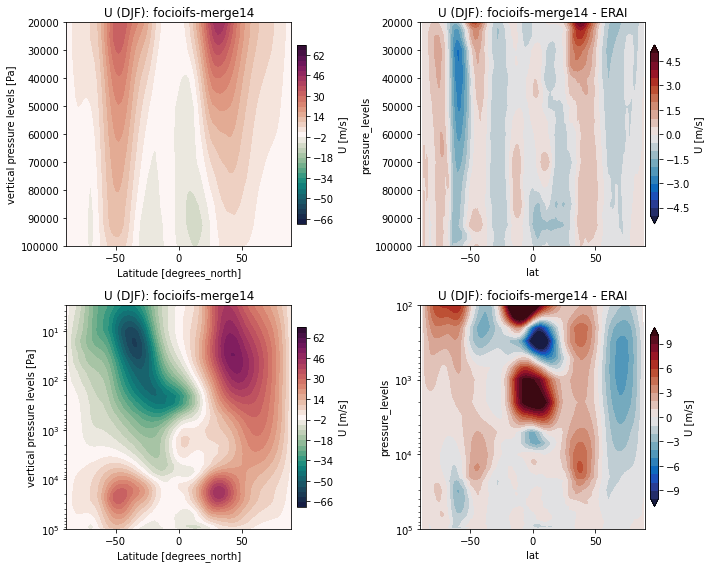

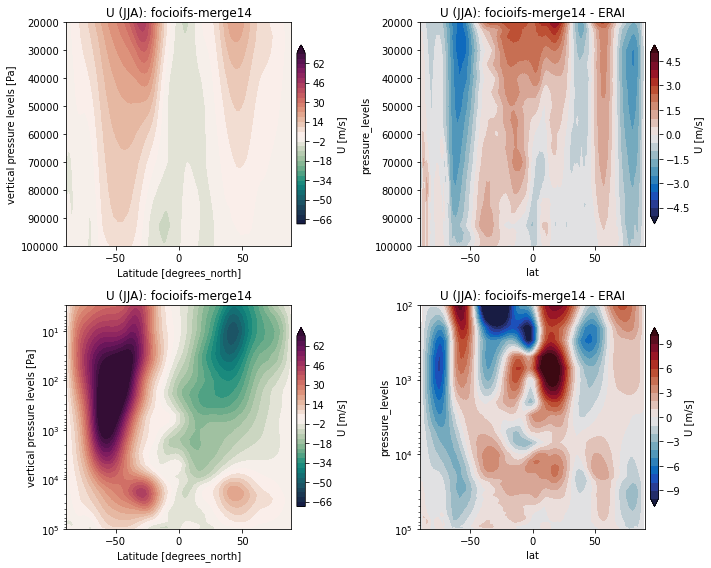

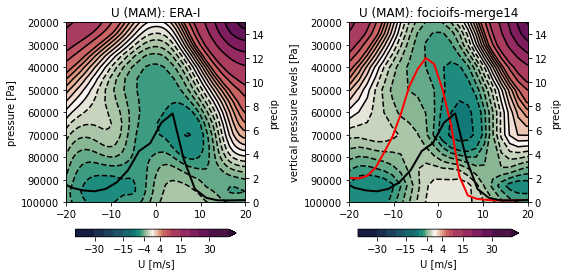

In [30]:
# Plot settings
prj = ccrs.PlateCarree()
umin1 = -70
umax1 = 70
umin2 = -5
umax2 = 5
umin3 = -10
umax3 = 10

ulevels1 = np.linspace(umin1,umax1,36)
ulevels2 = np.linspace(umin2,umax2,21)
ulevels3 = np.linspace(umin3,umax3,21)

umap1 = cmocean.cm.curl
umap2 = cmocean.cm.balance

# ERA-Int
era_u = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/u/u-eraint_monthly_0.75deg_1979-2016.nc'
ds_era_u = xr.open_dataset(era_u).rename({'lev':'pressure_levels'})
u_ei = ds_era_u['U'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
u_zm_ei = u_ei.mean('lon')

# GPCP
gpcp = '/data/user/swahl/reanalysis_obs/GPCP/precip.mon.mean.1979-01_2014-07.nc'
ds_gpcp = xr.open_dataset(gpcp)
tp_gpcp = ds_gpcp['precip'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_pl_all)):
    exp = exp_list[i]
    ds_pl = ds_pl_all[i]
    ds_sfc = ds_sfc_all[i]
    
    u = ds_pl['u'][-360:].groupby('time.season').mean('time') 
    u_zm = u.mean('lon')
    
    u_zm_i = u_zm.interp_like(u_zm_ei)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(10,8))
        axs = []
        axs.append( fig.add_subplot(2,2,1) )
        axs.append( fig.add_subplot(2,2,2) )
        axs.append( fig.add_subplot(2,2,3) )
        axs.append( fig.add_subplot(2,2,4) )
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]'}
        #u_zm.sel(season=season).plot(x='lat',y='pressure_levels',ax=axs[0],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        #(u_zm_i - u_zm_ei).sel(season=season).plot(ax=axs[1],cmap=umap2,vmin=umin2,vmax=umax2,cbar_kwargs=ckw)
        #u_zm.sel(season=season).plot(x='lat',y='pressure_levels',ax=axs[2],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        #(u_zm_i - u_zm_ei).sel(season=season).plot(ax=axs[3],cmap=umap2,vmin=umin3,vmax=umax3,cbar_kwargs=ckw)
        u_zm.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs[0],levels=ulevels1,cmap=umap1,cbar_kwargs=ckw)
        (u_zm_i - u_zm_ei).sel(season=season).plot.contourf(ax=axs[1],cmap=umap2,levels=ulevels2,cbar_kwargs=ckw)
        u_zm.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs[2],levels=ulevels1,cmap=umap1,cbar_kwargs=ckw)
        (u_zm_i - u_zm_ei).sel(season=season).plot.contourf(ax=axs[3],cmap=umap2,levels=ulevels3,cbar_kwargs=ckw)
        
        #u_zm.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs[1],levels=ulevels1[::4],colors='g')
        #u_zm.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs[3],levels=ulevels1[::4],colors='g')
        
        axs[0].set_title('U (%s): %s' % (season,exp))
        axs[1].set_title('U (%s): %s - ERAI' % (season,exp))
        axs[2].set_title('U (%s): %s' % (season,exp))
        axs[3].set_title('U (%s): %s - ERAI' % (season,exp))
        
        for ax in axs[0:2]:
            ax.set_ylim([20000,100000])
            
        for ax in axs:
            ax.invert_yaxis()
        
        for ax in axs[2:]:
            ax.set_yscale('log')
        
        fig.tight_layout()
        fig.savefig('u_biases_%s.png' % (season,),format='png',dpi=600)
    
    
    # Precip
    tp = ds_sfc['tp'][-360:].groupby('time.season').mean('time')
    tp_ta = tp.sel(lon=slice(320,350)).mean('lon') * 1000  #mm/d
    tp_ta_gpcp = tp_gpcp.sel(lon=slice(320,350)).mean('lon')
    
    fig2 = plt.figure(figsize=(8,4))
    axs2 = []
    axs2.append( fig2.add_subplot(1,2,1) )
    axs2.append( fig2.add_subplot(1,2,2) )
    
    umin1 = -20
    umax1 = 20
    tmp = np.array([1,2,3,4,5,6,8,10,15,20,25,30,40])
    tmp0 = np.array([0,1,2,3,4,5,6,8,10,15,20,25,30,40])
    ticks = np.array([4,15,30])
    ticks0 = np.array([4,15,30])
    ulevels = np.concatenate([-tmp[::-1], tmp0],axis=0)
    uticks  = np.concatenate([-ticks[::-1], ticks0],axis=0)

    season = 'MAM'
    u_ta_ei = u_ei.sel(lon=slice(320,350)).mean('lon')
    u_ta    = u.sel(lon=slice(320,350)).mean('lon')
    u_ta_i  = u_ta.interp_like(u_ta_ei)
    
    ckw = {'shrink':0.9, 'pad':0.11, 'orientation':'horizontal', 'extend':'both', 'label':'U [m/s]', 'ticks': uticks, 'spacing': 'proportional'}
    u_ta_ei.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs2[0],levels=ulevels,cmap=umap1,cbar_kwargs=ckw)
    u_ta.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs2[1],levels=ulevels,cmap=umap1,cbar_kwargs=ckw)
    u_ta_ei.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs2[0],levels=ulevels,colors='k')
    u_ta.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs2[1],levels=ulevels,colors='k')
    
    
    ax21 = axs2[0].twinx()
    tp_ta_gpcp.sel(season=season).plot(x='lat',ax=ax21,linestyle='-',c='k',lw=2)
    ax22 = axs2[1].twinx()
    tp_ta.sel(season=season).plot(x='lat',ax=ax22,linestyle='-',c='r',lw=2)
    tp_ta_gpcp.sel(season=season).plot(x='lat',ax=ax22,linestyle='-',c='k',lw=2)
    
    axs2[0].set_title('U (%s): ERA-I' % (season,))
    axs2[1].set_title('U (%s): %s' % (season,exp))
        
    for ax in axs2:
        ax.set_ylim([20000,100000])
        ax.invert_yaxis()
        ax.set_xlim([-20,20])
        ax.set_xlabel('')
    
    for ax in [ax21,ax22]:
        ax.set_title('')
        ax.set_ylim([0,15])
        ax.set_xlabel('')
    
    fig2.tight_layout()
    fig2.savefig('tatl_biases_as_harlass_%s.png' % (exp,),format='png',dpi=600)


## Temperature biases

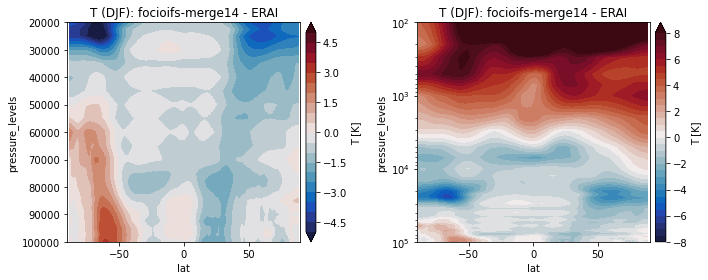

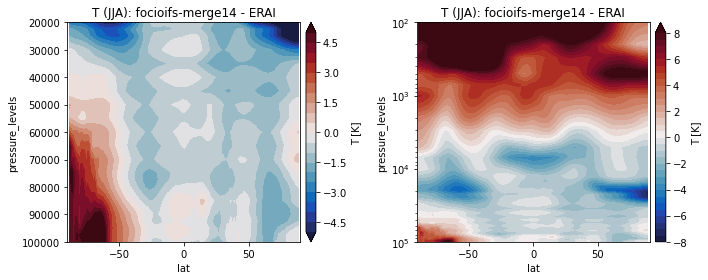

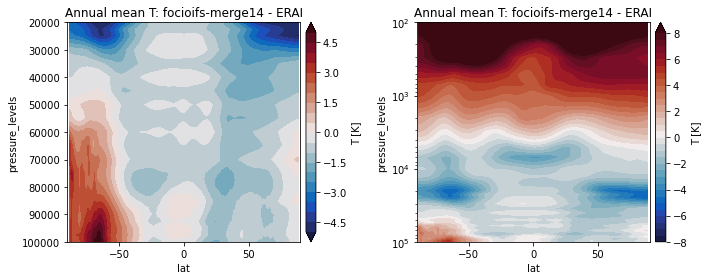

In [38]:
# Plot settings
prj = ccrs.PlateCarree()
tmin1 = 210
tmax1 = 300
tmin2 = -5
tmax2 = 5
tmin3 = -8
tmax3 = 8

tlevels1 = np.linspace(tmin1,tmax1,21)
tlevels2 = np.linspace(tmin2,tmax2,21)
tlevels3 = np.linspace(tmin3,tmax3,33)

tmap1 = cmocean.cm.thermal
tmap2 = cmocean.cm.balance

# ERA-Int
era_t = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/t/t-eraint_monthly_0.75deg_1979-2016.nc'
ds_era_t = xr.open_dataset(era_t).rename({'lev':'pressure_levels'})
t_ei = ds_era_t['T'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
t_zm_ei = t_ei.mean('lon')

for i in range(0,len(ds_pl_all)):
    exp = exp_list[i]
    ds_pl = ds_pl_all[i]
    ds_sfc = ds_sfc_all[i]
    
    t = ds_pl['t'][-360:].groupby('time.season').mean('time') 
    t_zm = t.mean('lon')
    
    t_zm_i = t_zm.interp_like(t_zm_ei)
    
    for season in ['DJF','JJA','Ann']:
        fig = plt.figure(figsize=(10,4))
        axs = []
        axs.append( fig.add_subplot(1,2,1) )
        axs.append( fig.add_subplot(1,2,2) )
        
        ckw = {'shrink':1.0, 'pad':0.02, 'extend':'both', 'label':'T [K]'}
        if season == 'Ann':
            zplot = (t_zm_i - t_zm_ei).mean('season')
        else:
            zplot = (t_zm_i - t_zm_ei).sel(season=season)
        
        zplot.plot.contourf(ax=axs[0],cmap=tmap2,levels=tlevels2,cbar_kwargs=ckw)
        zplot.plot.contourf(ax=axs[1],cmap=tmap2,levels=tlevels3,cbar_kwargs=ckw)
        
        if season == 'Ann':
            axs[0].set_title('Annual mean T: %s - ERAI' % (exp,))
            axs[1].set_title('Annual mean T: %s - ERAI' % (exp,))
        else:
            axs[0].set_title('T (%s): %s - ERAI' % (season,exp))
            axs[1].set_title('T (%s): %s - ERAI' % (season,exp))
        
        axs[0].set_ylim([20000,100000])
        axs[1].set_ylim([100,100000])
        
        for ax in axs:
            ax.invert_yaxis()
        
        axs[1].set_yscale('log')
        
        fig.tight_layout()
        fig.savefig('t_biases_%s.png' % (season,),format='png',dpi=600)